# Multi-Asset Percentile Momentum Strategy

This notebook implements percentile-based momentum strategies with:
- **Customizable lookback period** (default 14 days)
- **Multi-asset selection** (top N and bottom N assets)
- **Two strategy variants**:
  - **Neutral Strategy**: Always long top N, short bottom N
  - **Conditional Strategy**: Only trade when directional signals are clear

The strategies select assets based on recent performance rankings and implement different execution rules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from tqdm import tqdm

In [2]:
# Load data
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    min_records=30,
    min_volume=1e5,
    start_date="2021-01-01",
    end_date=None
)

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 551 USDT trading pairs
✓ BTCUSDT loaded successfully with 1732 records, avg volume: 359,624
Loaded 517 cryptocurrencies
Filtered 32 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 516 tickers over 1732 dates...
Precomputed returns matrix shape: (1732, 516)
Date range: 2021-01-01 00:00:00 to 2025-09-28 00:00:00


In [3]:
# Get price matrix
price = data_loader.get_price_matrix()
print(f"Price matrix shape: {price.shape}")
print(f"Date range: {price.index[0]} to {price.index[-1]}")

Price matrix shape: (1732, 516)
Date range: 2021-01-01 00:00:00 to 2025-09-28 00:00:00


In [4]:
# Strategy parameters - CUSTOMIZABLE
lookback_days = 14  # Lookback period for returns calculation
n_assets = 5        # Number of assets to go long/short
n_universe = 50     # Top N volume universe to select from each day
fees = 0.0005       # 5bps transaction fees per trade
vol_window = 30     # Volatility calculation window

print(f"Strategy Parameters:")
print(f"  Lookback period: {lookback_days} days")
print(f"  Assets per side: {n_assets}")
print(f"  Universe size: {n_universe}")
print(f"  Transaction fees: {fees*100:.2f} bps")

Strategy Parameters:
  Lookback period: 14 days
  Assets per side: 5
  Universe size: 50
  Transaction fees: 0.05 bps


In [5]:
# Prepare volume data for universe selection
volume_data = {}
for ticker in data_loader.get_universe():
    ticker_data = data_loader._crypto_universe[ticker]['data']
    volume_data[ticker] = ticker_data['volume'].reindex(price.index)

volume_matrix = pd.DataFrame(volume_data, index=price.index)
rolling_volume_matrix = volume_matrix.rolling(window=20, min_periods=10).mean()

# Calculate rolling volatility for risk management
volatility = price.pct_change().rolling(vol_window).std()

print(f"Volume matrix shape: {volume_matrix.shape}")
print(f"Rolling volume matrix shape: {rolling_volume_matrix.shape}")

C:\Users\USER\AppData\Local\Temp\ipykernel_2140\2863702676.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatility = price.pct_change().rolling(vol_window).std()


Volume matrix shape: (1732, 516)
Rolling volume matrix shape: (1732, 516)


In [6]:
# Calculate N-day returns
nday_returns = price.pct_change(lookback_days)

print(f"N-day returns shape: {nday_returns.shape}")
print(f"First valid return date: {nday_returns.dropna().index[0]}")

# Start from halfway through dataset to build sufficient history
start_idx = max(lookback_days * 2, len(price) // 2)
print(f"Starting strategy from index {start_idx} ({price.index[start_idx]})")

C:\Users\USER\AppData\Local\Temp\ipykernel_2140\881376076.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  nday_returns = price.pct_change(lookback_days)


N-day returns shape: (1732, 516)
First valid return date: 2025-09-12 00:00:00
Starting strategy from index 866 (2023-05-17 00:00:00)


In [7]:
# Initialize tracking variables
equity_neutral = [1.0]      # Always long/short strategy
equity_pos_neg = [1.0]      # Conditional strategy
strategy_log_neutral = []   # Track strategy actions
strategy_log_pos_neg = []   # Track strategy actions

print(f"Running percentile momentum strategies...")
print(f"Processing {len(price) - start_idx - 1} periods")

for i in tqdm(range(start_idx, len(price) - 1)):
    current_date = price.index[i]
    
    # Get volume-filtered universe
    current_volumes = rolling_volume_matrix.iloc[i].dropna()
    if len(current_volumes) == 0:
        equity_neutral.append(equity_neutral[-1])
        equity_pos_neg.append(equity_pos_neg[-1])
        strategy_log_neutral.append('cash')
        strategy_log_pos_neg.append('cash')
        continue
    
    # Select top N_universe by volume
    top_volume_tickers = current_volumes.nlargest(n_universe).index
    
    # Get current N-day returns for volume-filtered universe
    current_returns = nday_returns.iloc[i][top_volume_tickers].dropna()
    
    if len(current_returns) < n_assets * 2:  # Need enough assets for long/short
        equity_neutral.append(equity_neutral[-1])
        equity_pos_neg.append(equity_pos_neg[-1])
        strategy_log_neutral.append('cash')
        strategy_log_pos_neg.append('cash')
        continue
    
    # Select top and bottom performers
    long_assets = current_returns.nlargest(n_assets).index
    short_assets = current_returns.nsmallest(n_assets).index
    
    # Get the actual return values for decision making
    best_return = current_returns.max()
    worst_return = current_returns.min()
    
    # Calculate next-day returns for selected assets
    long_next_returns = []
    short_next_returns = []
    
    # Long positions returns
    for asset in long_assets:
        p0 = price[asset].iat[i]
        p1 = price[asset].iat[i+1]
        if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
            asset_return = (p1 - p0) / p0
            long_next_returns.append(asset_return)
    
    # Short positions returns
    for asset in short_assets:
        p0 = price[asset].iat[i]
        p1 = price[asset].iat[i+1]
        if np.isfinite(p0) and p0 != 0 and np.isfinite(p1):
            asset_return = (p1 - p0) / p0
            short_next_returns.append(asset_return)
    
    if not long_next_returns or not short_next_returns:
        equity_neutral.append(equity_neutral[-1])
        equity_pos_neg.append(equity_pos_neg[-1])
        strategy_log_neutral.append('cash')
        strategy_log_pos_neg.append('cash')
        continue
    
    # Calculate average returns
    avg_long_return = np.mean(long_next_returns)
    avg_short_return = np.mean(short_next_returns)
    
    # === NEUTRAL STRATEGY ===
    # Always long top performers, short bottom performers
    neutral_return = avg_long_return - avg_short_return - fees  # Fees for long+short
    equity_neutral.append(equity_neutral[-1] * (1 + neutral_return))
    strategy_log_neutral.append('long_short')
    
    # === CONDITIONAL STRATEGY ===
    # Only trade when directional signals are clear
    if best_return > 0 and worst_return < 0:
        # Clear directional signal: long winners, short losers
        pos_neg_return = avg_long_return - avg_short_return - fees
        strategy_action = 'long_short'
    elif best_return > 0:
        # Only positive momentum: long only
        pos_neg_return = avg_long_return - fees/2  # Half fees for long only
        strategy_action = 'long_only'
    elif worst_return < 0:
        # Only negative momentum: short only
        pos_neg_return = -avg_short_return - fees/2  # Half fees for short only
        strategy_action = 'short_only'
    else:
        # No clear signal: hold cash
        pos_neg_return = 0
        strategy_action = 'cash'
    
    equity_pos_neg.append(equity_pos_neg[-1] * (1 + pos_neg_return))
    strategy_log_pos_neg.append(strategy_action)

print(f"\nBacktest completed!")
print(f"Neutral strategy final equity: {equity_neutral[-1]:.4f}")
print(f"Conditional strategy final equity: {equity_pos_neg[-1]:.4f}")

Running percentile momentum strategies...
Processing 865 periods


100%|███████████████████████████████████████████████████████████████████████| 865/865 [00:06<00:00, 135.78it/s]



Backtest completed!
Neutral strategy final equity: 0.9559
Conditional strategy final equity: 1.3550


In [8]:
# Create results DataFrames
results_dates = price.index[start_idx:start_idx + len(equity_neutral)]

results_neutral = pd.DataFrame({
    'equity': equity_neutral,
    'strategy': ['start'] + strategy_log_neutral
}, index=results_dates)

results_pos_neg = pd.DataFrame({
    'equity': equity_pos_neg,
    'strategy': ['start'] + strategy_log_pos_neg
}, index=results_dates)

# Strategy usage statistics
print("=== NEUTRAL STRATEGY USAGE ===")
neutral_counts = results_neutral['strategy'].value_counts()
for strategy, count in neutral_counts.items():
    pct = count / len(results_neutral) * 100
    print(f"  {strategy}: {count} days ({pct:.1f}%)")

print("\n=== CONDITIONAL STRATEGY USAGE ===")
pos_neg_counts = results_pos_neg['strategy'].value_counts()
for strategy, count in pos_neg_counts.items():
    pct = count / len(results_pos_neg) * 100
    print(f"  {strategy}: {count} days ({pct:.1f}%)")

=== NEUTRAL STRATEGY USAGE ===
  long_short: 865 days (99.9%)
  start: 1 days (0.1%)

=== CONDITIONAL STRATEGY USAGE ===
  long_short: 849 days (98.0%)
  long_only: 16 days (1.8%)
  start: 1 days (0.1%)


In [9]:
# Performance metrics function
def calculate_performance_metrics(equity_series, strategy_name):
    total_return = (equity_series.iloc[-1] - 1) * 100
    daily_returns = equity_series.pct_change().dropna()
    
    ann_return = daily_returns.mean() * 252 * 100
    ann_vol = daily_returns.std() * np.sqrt(252) * 100
    sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
    max_dd = (equity_series / equity_series.cummax() - 1).min() * 100
    
    win_rate = (daily_returns > 0).mean() * 100
    
    print(f"\n=== {strategy_name.upper()} PERFORMANCE ===")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Annualized Return: {ann_return:.2f}%")
    print(f"Annualized Volatility: {ann_vol:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.3f}")
    print(f"Maximum Drawdown: {max_dd:.2f}%")
    print(f"Win Rate: {win_rate:.1f}%")
    
    return {
        'total_return': total_return,
        'ann_return': ann_return,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'win_rate': win_rate
    }

# Calculate performance for both strategies
neutral_equity = pd.Series(equity_neutral, index=results_dates)
pos_neg_equity = pd.Series(equity_pos_neg, index=results_dates)

neutral_perf = calculate_performance_metrics(neutral_equity, "Neutral Strategy")
pos_neg_perf = calculate_performance_metrics(pos_neg_equity, "Conditional Strategy")

# BTC comparison
btc_cumret = (1 + price["BTCUSDT"].pct_change().fillna(0)).cumprod()
btc_aligned = btc_cumret.reindex(results_dates)
btc_perf = calculate_performance_metrics(btc_aligned, "BTC Buy & Hold")


=== NEUTRAL STRATEGY PERFORMANCE ===
Total Return: -4.41%
Annualized Return: 56.85%
Annualized Volatility: 118.54%
Sharpe Ratio: 0.480
Maximum Drawdown: -90.33%
Win Rate: 48.7%

=== CONDITIONAL STRATEGY PERFORMANCE ===
Total Return: 35.50%
Annualized Return: 66.74%
Annualized Volatility: 118.36%
Sharpe Ratio: 0.564
Maximum Drawdown: -90.22%
Win Rate: 48.7%

=== BTC BUY & HOLD PERFORMANCE ===
Total Return: 274.24%
Annualized Return: 47.82%
Annualized Volatility: 38.51%
Sharpe Ratio: 1.242
Maximum Drawdown: -28.10%
Win Rate: 52.0%


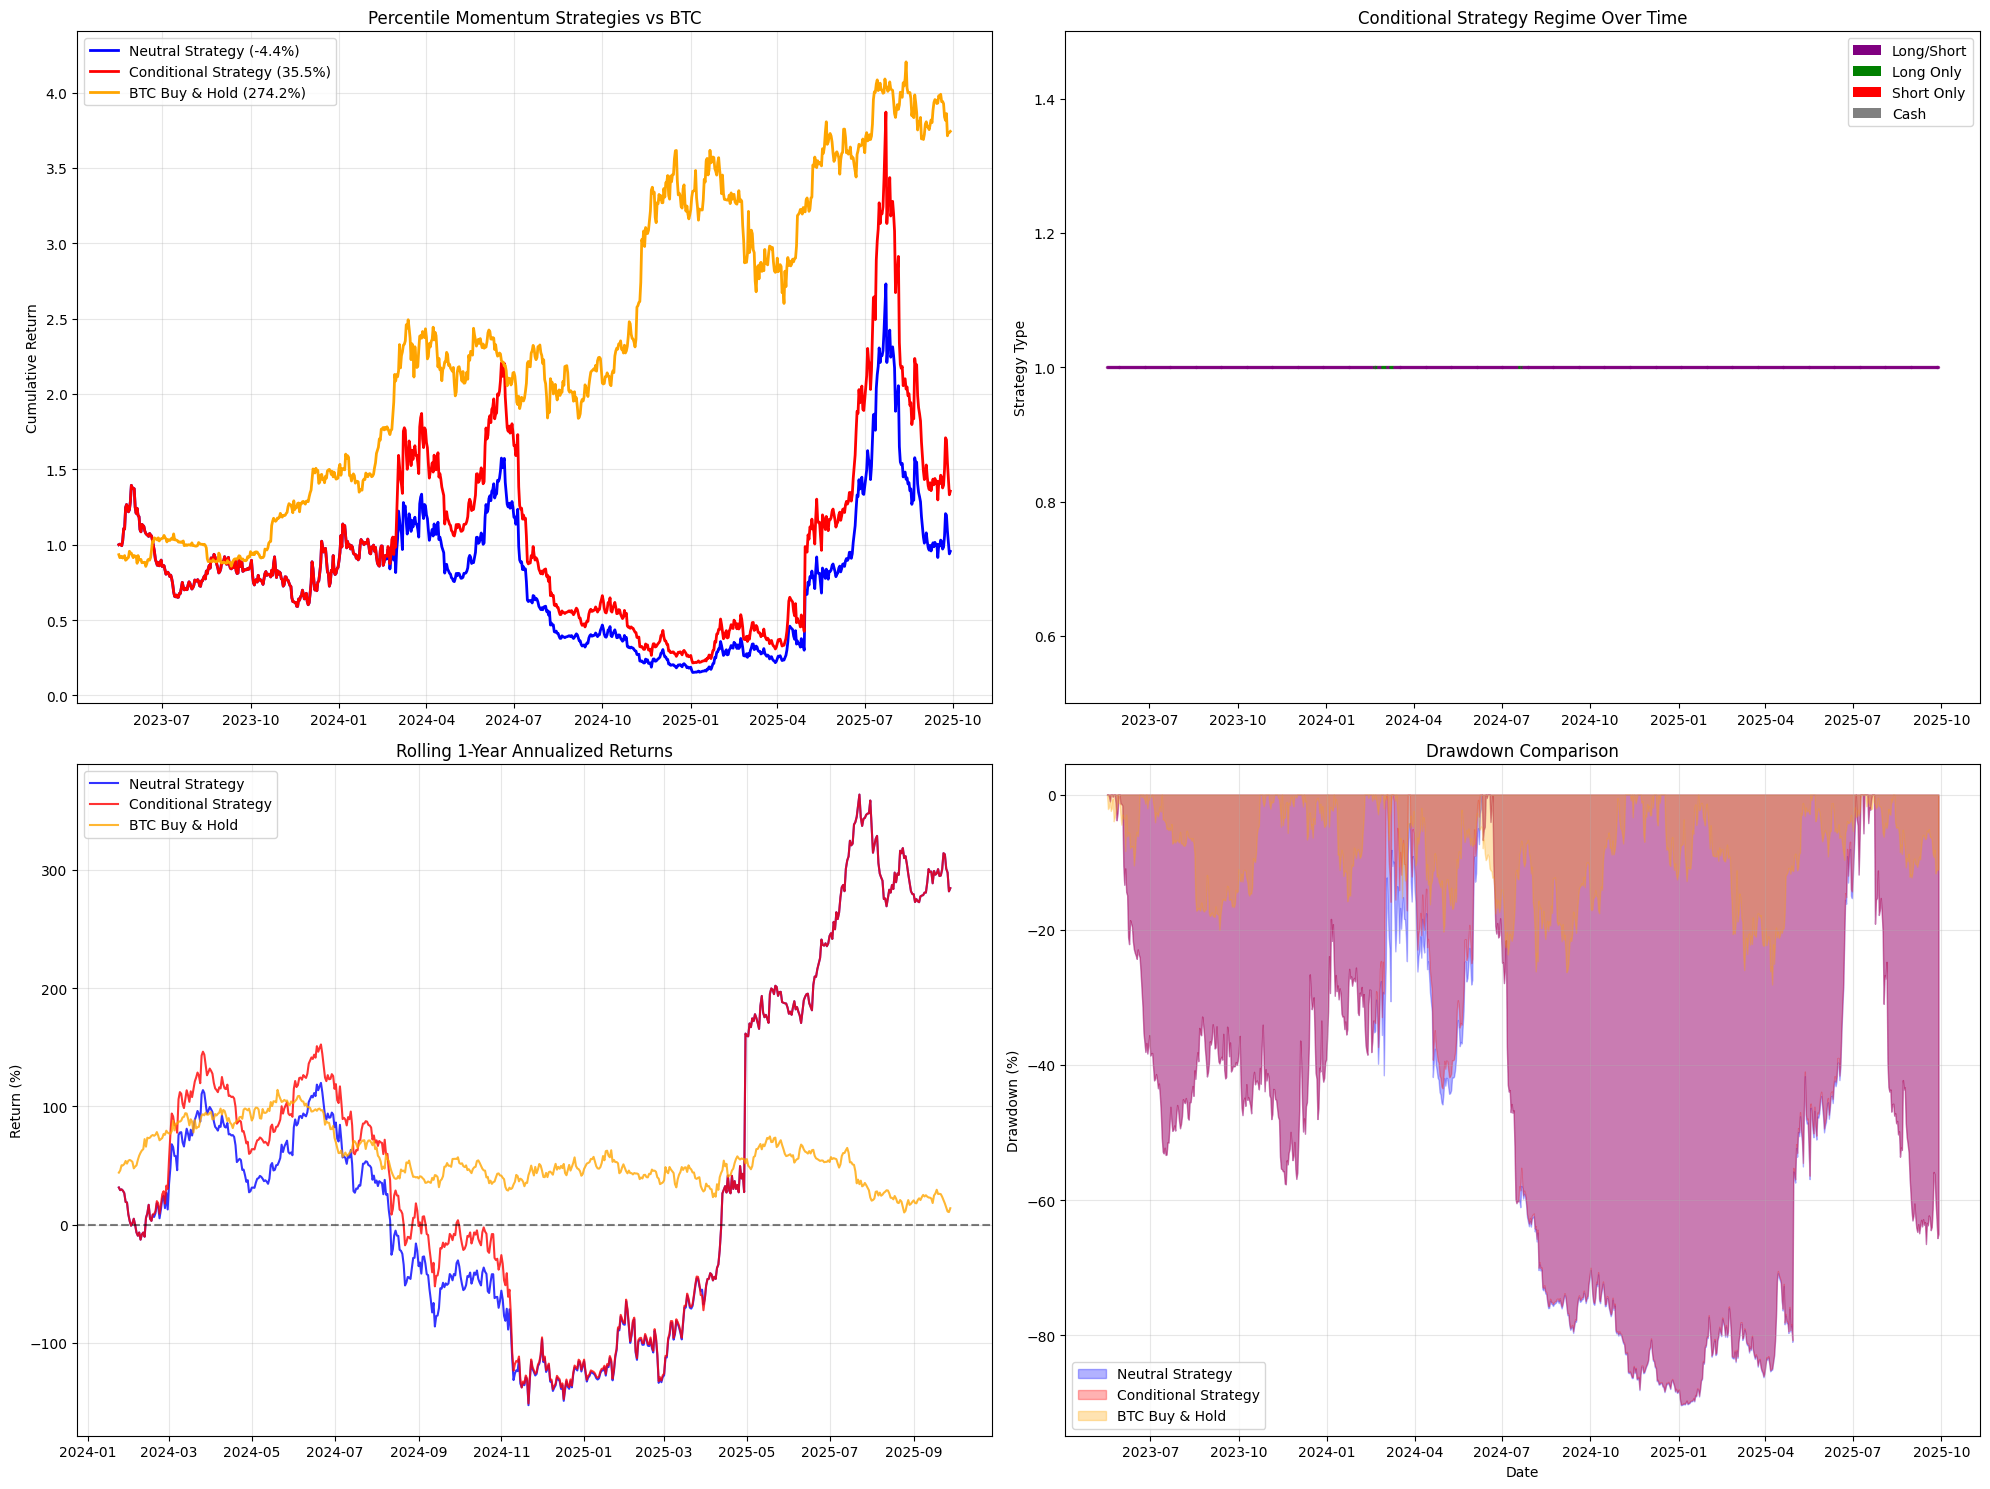

In [10]:
# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Equity curves comparison
ax1.plot(neutral_equity.index, neutral_equity, 
         label=f'Neutral Strategy ({neutral_perf["total_return"]:.1f}%)', linewidth=2, color='blue')
ax1.plot(pos_neg_equity.index, pos_neg_equity, 
         label=f'Conditional Strategy ({pos_neg_perf["total_return"]:.1f}%)', linewidth=2, color='red')
ax1.plot(btc_aligned.index, btc_aligned, 
         label=f'BTC Buy & Hold ({btc_perf["total_return"]:.1f}%)', linewidth=2, color='orange')
ax1.set_title('Percentile Momentum Strategies vs BTC')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Strategy regime visualization for conditional strategy
strategy_colors = {
    'long_short': 'purple', 
    'long_only': 'green', 
    'short_only': 'red', 
    'cash': 'gray',
    'start': 'black'
}

for i, (date, strategy) in enumerate(zip(results_pos_neg.index, results_pos_neg['strategy'])):
    if i > 0:  # Skip first point
        ax2.scatter(date, 1, c=strategy_colors.get(strategy, 'black'), alpha=0.7, s=2)

ax2.set_title('Conditional Strategy Regime Over Time')
ax2.set_ylabel('Strategy Type')
ax2.set_ylim(0.5, 1.5)

# Add legend for strategy colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='purple', label='Long/Short'),
    Patch(facecolor='green', label='Long Only'),
    Patch(facecolor='red', label='Short Only'),
    Patch(facecolor='gray', label='Cash')
]
ax2.legend(handles=legend_elements)

# Rolling returns comparison
window = 252
neutral_rolling = neutral_equity.pct_change().rolling(window).mean() * 252 * 100
pos_neg_rolling = pos_neg_equity.pct_change().rolling(window).mean() * 252 * 100
btc_rolling = btc_aligned.pct_change().rolling(window).mean() * 252 * 100

ax3.plot(neutral_rolling.index, neutral_rolling, label='Neutral Strategy', color='blue', alpha=0.8)
ax3.plot(pos_neg_rolling.index, pos_neg_rolling, label='Conditional Strategy', color='red', alpha=0.8)
ax3.plot(btc_rolling.index, btc_rolling, label='BTC Buy & Hold', color='orange', alpha=0.8)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Rolling 1-Year Annualized Returns')
ax3.set_ylabel('Return (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Drawdown comparison
neutral_dd = (neutral_equity / neutral_equity.cummax() - 1) * 100
pos_neg_dd = (pos_neg_equity / pos_neg_equity.cummax() - 1) * 100
btc_dd = (btc_aligned / btc_aligned.cummax() - 1) * 100

ax4.fill_between(neutral_dd.index, neutral_dd, 0, alpha=0.3, color='blue', label='Neutral Strategy')
ax4.fill_between(pos_neg_dd.index, pos_neg_dd, 0, alpha=0.3, color='red', label='Conditional Strategy')
ax4.fill_between(btc_dd.index, btc_dd, 0, alpha=0.3, color='orange', label='BTC Buy & Hold')
ax4.set_title('Drawdown Comparison')
ax4.set_ylabel('Drawdown (%)')
ax4.set_xlabel('Date')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Performance comparison table
comparison_df = pd.DataFrame({
    'Neutral Strategy': [neutral_perf['total_return'], neutral_perf['ann_return'], 
                        neutral_perf['ann_vol'], neutral_perf['sharpe'], 
                        neutral_perf['max_dd'], neutral_perf['win_rate']],
    'Conditional Strategy': [pos_neg_perf['total_return'], pos_neg_perf['ann_return'], 
                            pos_neg_perf['ann_vol'], pos_neg_perf['sharpe'], 
                            pos_neg_perf['max_dd'], pos_neg_perf['win_rate']],
    'BTC Buy & Hold': [btc_perf['total_return'], btc_perf['ann_return'], 
                      btc_perf['ann_vol'], btc_perf['sharpe'], 
                      btc_perf['max_dd'], btc_perf['win_rate']]
}, index=['Total Return (%)', 'Ann. Return (%)', 'Ann. Volatility (%)', 
          'Sharpe Ratio', 'Max Drawdown (%)', 'Win Rate (%)'])

print("\n" + "="*80)
print("PERFORMANCE COMPARISON TABLE")
print("="*80)
print(comparison_df.round(2))

# Strategy insights
print(f"\n" + "="*80)
print("STRATEGY INSIGHTS")
print("="*80)

print(f"\nStrategy Parameters Used:")
print(f"  Lookback period: {lookback_days} days")
print(f"  Assets per side: {n_assets}")
print(f"  Universe size: {n_universe}")

print(f"\nKey Findings:")
if neutral_perf['sharpe'] > pos_neg_perf['sharpe']:
    print(f"• Neutral strategy outperforms conditional strategy (Sharpe: {neutral_perf['sharpe']:.3f} vs {pos_neg_perf['sharpe']:.3f})")
else:
    print(f"• Conditional strategy outperforms neutral strategy (Sharpe: {pos_neg_perf['sharpe']:.3f} vs {neutral_perf['sharpe']:.3f})")

if neutral_perf['max_dd'] > pos_neg_perf['max_dd']:
    print(f"• Conditional strategy has lower drawdown ({abs(pos_neg_perf['max_dd']):.1f}% vs {abs(neutral_perf['max_dd']):.1f}%)")
else:
    print(f"• Neutral strategy has lower drawdown ({abs(neutral_perf['max_dd']):.1f}% vs {abs(pos_neg_perf['max_dd']):.1f}%)")

cash_pct = (results_pos_neg['strategy'] == 'cash').mean() * 100
print(f"• Conditional strategy holds cash {cash_pct:.1f}% of the time")

both_beat_btc = (neutral_perf['sharpe'] > btc_perf['sharpe']) and (pos_neg_perf['sharpe'] > btc_perf['sharpe'])
if both_beat_btc:
    print(f"• Both strategies outperform BTC buy-and-hold on risk-adjusted basis")
else:
    print(f"• BTC buy-and-hold competitive on risk-adjusted basis (Sharpe: {btc_perf['sharpe']:.3f})")


PERFORMANCE COMPARISON TABLE
                     Neutral Strategy  Conditional Strategy  BTC Buy & Hold
Total Return (%)                -4.41                 35.50          274.24
Ann. Return (%)                 56.85                 66.74           47.82
Ann. Volatility (%)            118.54                118.36           38.51
Sharpe Ratio                     0.48                  0.56            1.24
Max Drawdown (%)               -90.33                -90.22          -28.10
Win Rate (%)                    48.67                 48.67           52.02

STRATEGY INSIGHTS

Strategy Parameters Used:
  Lookback period: 14 days
  Assets per side: 5
  Universe size: 50

Key Findings:
• Conditional strategy outperforms neutral strategy (Sharpe: 0.564 vs 0.480)
• Neutral strategy has lower drawdown (90.3% vs 90.2%)
• Conditional strategy holds cash 0.0% of the time
• BTC buy-and-hold competitive on risk-adjusted basis (Sharpe: 1.242)


In [12]:
# Parameter sensitivity analysis (optional)
print(f"\n" + "="*80)
print("PARAMETER SENSITIVITY NOTES")
print("="*80)

print(f"\nCurrent parameters:")
print(f"  lookback_days = {lookback_days}")
print(f"  n_assets = {n_assets}")
print(f"  n_universe = {n_universe}")
print(f"  fees = {fees}")

print(f"\nTo test different parameters, modify the values in cell 4 and re-run:")
print(f"  • lookback_days: Try 7, 14, 21, 30 for different momentum horizons")
print(f"  • n_assets: Try 3, 5, 8, 10 for different concentration levels")
print(f"  • n_universe: Try 30, 50, 100 for different universe sizes")
print(f"  • fees: Try 0.0001, 0.0005, 0.001 for different cost assumptions")

print(f"\nExpected relationships:")
print(f"  • Shorter lookback → Higher turnover, more sensitive to recent moves")
print(f"  • More assets → Lower concentration risk, potentially lower returns")
print(f"  • Larger universe → More assets to choose from, better diversification")
print(f"  • Higher fees → Lower net returns, especially for high-turnover strategies")


PARAMETER SENSITIVITY NOTES

Current parameters:
  lookback_days = 14
  n_assets = 5
  n_universe = 50
  fees = 0.0005

To test different parameters, modify the values in cell 4 and re-run:
  • lookback_days: Try 7, 14, 21, 30 for different momentum horizons
  • n_assets: Try 3, 5, 8, 10 for different concentration levels
  • n_universe: Try 30, 50, 100 for different universe sizes
  • fees: Try 0.0001, 0.0005, 0.001 for different cost assumptions

Expected relationships:
  • Shorter lookback → Higher turnover, more sensitive to recent moves
  • More assets → Lower concentration risk, potentially lower returns
  • Larger universe → More assets to choose from, better diversification
  • Higher fees → Lower net returns, especially for high-turnover strategies
